# TASK 2 - VENTRAL TEMPORAL 50 % RANDOM FEATURES

- Face Vs House Classification
- Face Vs Bottles Classification

## FACES VS HOUSE CLASSIFICATION

## Install Required Libraries

In [1]:
pip install nilearn

Note: you may need to restart the kernel to use updated packages.


## Load the Dataset

In [2]:
from nilearn import datasets
subj2 = datasets.fetch_haxby(subjects=[2])

[get_dataset_dir] Dataset found in /Users/prisha/nilearn_data/haxby2001

## Analyse the Dataset

In [3]:
print(subj2.keys())

dict_keys(['anat', 'func', 'session_target', 'mask_vt', 'mask_face', 'mask_house', 'mask_face_little', 'mask_house_little', 'mask', 'description'])


Anatomical imaging, which uses medical imaging technology to visualize the structure of the body and its organs, is a critical tool in diagnosing and treating a variety of medical conditions. Here in order to understand the data we have plotted the anatomical images of the brain.

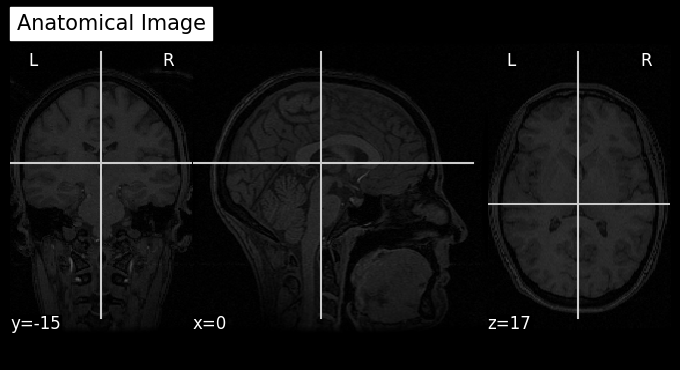

In [38]:
from nilearn import plotting

# Visualize the anatomical image
plotting.plot_anat(subj2['anat'][0], title="Anatomical Image")
plotting.show()

In [6]:
from nilearn.image import load_img

# Load the first functional scan
func_img = load_img(subj2['func'][0])

# Print basic information
print(f"Functional Image Shape: {func_img.shape}")


Functional Image Shape: (40, 64, 64, 1452)


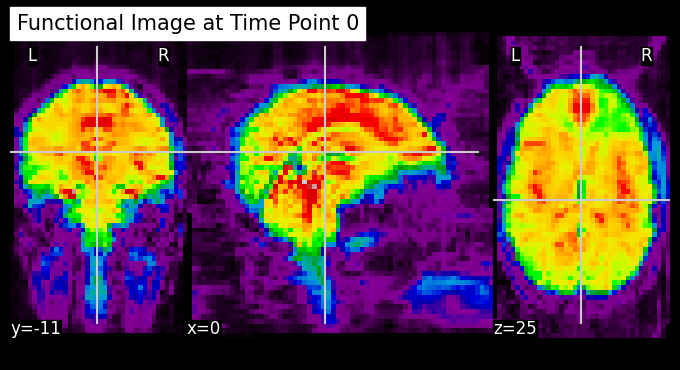

In [7]:
from nilearn import plotting
from nilearn.image import index_img

# Extract the functional image at time point 0
func_img_t0 = index_img(func_img, 0)

# Plot the first time point
plotting.plot_epi(func_img_t0, title="Functional Image at Time Point 0")
plotting.show()

This isolates the ventral temporal region, which is a focus of our assignment.

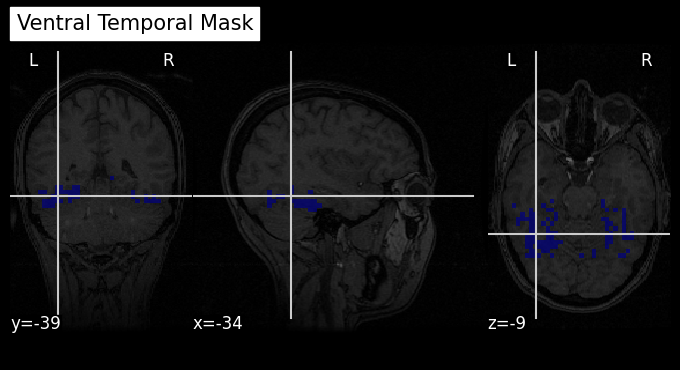

In [8]:
# Load and plot the mask
vt_mask_img = load_img(subj2['mask_vt'])
plotting.plot_roi(vt_mask_img, bg_img=subj2['anat'][0], title="Ventral Temporal Mask")
plotting.show()

This code highlights the regions that get activated during object detection of faces and houses, assuming that the masks (mask_face and mask_house)

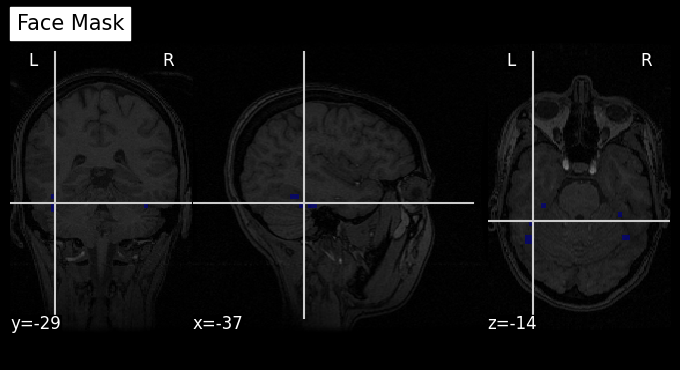

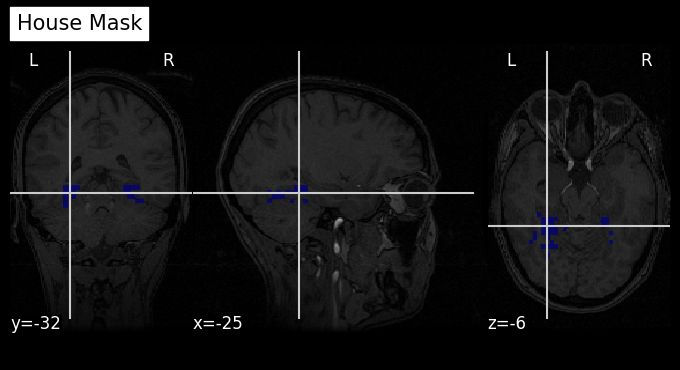

In [9]:
face_mask = load_img(subj2['mask_face'])
house_mask = load_img(subj2['mask_house'])

# Plot the masks
plotting.plot_roi(face_mask, bg_img=subj2['anat'][0], title="Face Mask")
plotting.plot_roi(house_mask, bg_img=subj2['anat'][0], title="House Mask")
plotting.show()

To understand how the ventral temporal region responds, extract time-series data corresponding to the voxels in the ventral temporal region .

In [10]:
from nilearn.maskers import NiftiMasker

# Create a masker for the ventral temporal region
masker = NiftiMasker(mask_img=vt_mask_img, standardize=True)
time_series = masker.fit_transform(func_img)

# Inspect the extracted time series
print(f"Time-series shape: {time_series.shape}")

Time-series shape: (1452, 464)


Interpretation of Shape:

- Rows (1452): Time points, indicating how the brain’s activity evolves over time.
- Columns (464): Spatial features (voxels) in the ROI, where activity is recorded.

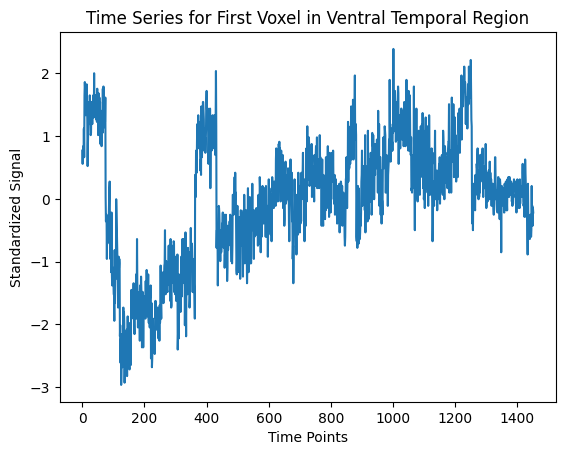

In [11]:
import matplotlib.pyplot as plt

# Plot the first voxel's time series, like for each time series we just plot the first poxel
plt.plot(time_series[:, 0])
plt.title("Time Series for First Voxel in Ventral Temporal Region")
plt.xlabel("Time Points")
plt.ylabel("Standardized Signal")
plt.show()

NiftiMasker is a tool in Nilearn that simplifies preprocessing of fMRI data.

- `mask_img=subj2['mask_vt'][0]`: Specifies the ventral temporal (VT) mask, which defines the region of the brain from which time-series data will be extracted.

- `standardize="zscore_sample"`: Normalizes the time-series data for each voxel using z-score standardization. Each voxel’s mean is subtracted, and the signal is scaled by its standard deviation. This ensures all signals are on a comparable scale.

- `detrend=True`: Removes low-frequency trends from the data, which could result from scanner drift or other artifacts. It helps focus on task-related signals.

- `high_variance_confounds=True`: Identifies and removes signals from voxels with high variance, which often correspond to noise or artifacts.

The masker contains these parameters, and after applying `fit_transform`, it will return the time-series data of the ventral temporal region. The `fit_transform` method applies the mask and preprocessing steps to the data, returning a 2D numpy array of the preprocessed time-series data.

In summary:
- NiftiMasker preprocesses neuroimaging data.

- `fit_transform` applies the mask and preprocessing steps to the data.

- Returns a 2D numpy array of the preprocessed time-series data.


In [52]:
from nilearn.maskers import NiftiMasker
masker = NiftiMasker(mask_img=subj2['mask_vt'][0],
                     standardize="zscore_sample",
                     detrend=True,
                     high_variance_confounds=True)


time_series = masker.fit_transform(subj2['func'][0])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/nilearn/image/resampling.py:489: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


In [53]:
print(subj2['session_target'])
print(subj2['session_target'][0])

['/Users/prisha/nilearn_data/haxby2001/subj2/labels.txt']
/Users/prisha/nilearn_data/haxby2001/subj2/labels.txt


In [54]:
import pandas as pd

# Load the behavioral data
behavioral = pd.read_csv(subj2['session_target'][0], sep=" ")

# Print the last few rows of the data
print(behavioral.tail())

# Extract and print unique labels
unique_labels = behavioral['labels'].unique()
print(f"Unique labels: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}")

     labels  chunks
1447   rest      11
1448   rest      11
1449   rest      11
1450   rest      11
1451   rest      11
Unique labels: ['rest' 'scissors' 'face' 'cat' 'shoe' 'house' 'scrambledpix' 'bottle'
 'chair']
Number of unique labels: 9


In [55]:
# Analyzing the shape that we would be working with
print(time_series.shape)
print(behavioral.shape)

(1452, 464)
(1452, 2)


### Prepare the dataset that would be used to train the model for classification, conditioned on the labels face and house.

In [56]:
import numpy as np

# Restrict to face, house conditions here
conditions = behavioral["labels"]
mask = conditions.isin(["face", "house"])

# Filter the time series and conditions using the mask
X = time_series[mask]
Y = conditions[mask]

# Get the number of features (columns) in the time series
n_features = X.shape[1]

# Randomly select 50% of the features (columns)
random_feature_indices = np.random.choice(n_features, size=n_features // 2, replace=False)

# Select 50% random features
X_random = X[:, random_feature_indices]

# Print the shapes of the original and modified feature sets
print(f"Original time series shape: {X.shape}")
print(f"Shape with 50% random features: {X_random.shape}")

# Now X_random can be used for training and testing
X=X_random

print(X.shape)
print(Y.shape)

Original time series shape: (216, 464)
Shape with 50% random features: (216, 232)
(216, 232)
(216,)


## Using Different Models for Classification

### Logistic Regression

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

print(X_train.shape)
print(X_test.shape)
# Initialize and train Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict and calculate accuracy
predicted_log_reg = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, predicted_log_reg))

(144, 232)
(72, 232)
Logistic Regression Accuracy: 0.9861111111111112


### Random Forest Classifier

In [58]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest model
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

# Predict and calculate accuracy
predicted_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, predicted_rf))

Random Forest Accuracy: 0.9861111111111112


In [59]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and train K-Nearest Neighbors model
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

# Predict and calculate accuracy
predicted_knn = knn.predict(X_test)
print("K-Nearest Neighbors Accuracy:", accuracy_score(y_test, predicted_knn))

K-Nearest Neighbors Accuracy: 0.9722222222222222


In [60]:
from sklearn.svm import LinearSVC
svc=LinearSVC()

svc.fit(X_train, y_train)
predicted_svc = svc.predict(X_test)

print("LinearSVC Accuracy:", accuracy_score(y_test, predicted_svc))

LinearSVC Accuracy: 1.0


#### Out of all the models that were tested (KNN, Random Forest, Logistic Regression), we see that LinearSVC performed the best because it is particularly effective for high-dimensional datasets, such as our fMRI data, where the number of features (voxels) is much larger than the number of samples (time points). Additionally, the linear nature of the model makes it computationally efficient and well-suited for binary classification tasks like ours.

Despite using just 50% of the features in this case rather than all features of the ventral temporal region, we achieve an accuracy of 1. This suggests that the selected features are highly informative and sufficient for the classification task.

## LeaveOneGroupOut cross validation strategy with LinearSVC

In [61]:
n_features = time_series.shape[1]
time_series_1=time_series
random_feature_indices = np.random.choice(n_features, size=n_features // 2, replace=False)
time_series=time_series[:, random_feature_indices]
print(time_series.shape)

(1452, 232)


In [62]:
accuracy_values1 = []

# Iterate through each of the 12 chunks (cross-validation)
for val in range(12):
    # Define the training and testing conditions for each chunk
    svc = LinearSVC()
    condition_mask_train = (mask) & (behavioral["chunks"] != val)
    condition_mask_test = (mask) & (behavioral["chunks"] == val)

    # Split the time series and labels based on the condition mask for training and testing
    X_train_selected = time_series[condition_mask_train]
    X_test_selected = time_series[condition_mask_test]
    y_train_selected = conditions[condition_mask_train]
    y_test_selected = conditions[condition_mask_test]

    # # Check shapes of training and test sets for debugging
    # print(f"\nTrain set shape (chunk {val}): {X_train_selected.shape}")
    # print(f"Test set shape (chunk {val}): {X_test_selected.shape}")


    # Train the model on the training data
    svc.fit(X_train_selected, y_train_selected)

    # Predict the labels for the test data
    predicted_selected = svc.predict(X_test_selected)

    # Calculate accuracy for this chunk and append to the list
    accuracy = accuracy_score(y_test_selected, predicted_selected)
    accuracy_values1.append(accuracy)

    # Print the accuracy for the current chunk
    print(f"Accuracy for the test chunk {val}: {accuracy}")



Accuracy for the test chunk 0: 0.9444444444444444
Accuracy for the test chunk 1: 1.0
Accuracy for the test chunk 2: 1.0
Accuracy for the test chunk 3: 0.9444444444444444
Accuracy for the test chunk 4: 1.0
Accuracy for the test chunk 5: 1.0
Accuracy for the test chunk 6: 1.0
Accuracy for the test chunk 7: 1.0
Accuracy for the test chunk 8: 1.0
Accuracy for the test chunk 9: 1.0
Accuracy for the test chunk 10: 1.0
Accuracy for the test chunk 11: 0.9444444444444444


In [63]:
# Compute the mean and standard deviation of the accuracies
mean_accuracy = np.mean(accuracy_values1)
std_accuracy = np.std(accuracy_values1)

# Print the overall performance
print(f"\nMean Accuracy across all chunks: {mean_accuracy}")
print(f"Standard Deviation of Accuracy: {std_accuracy}")



Mean Accuracy across all chunks: 0.9861111111111112
Standard Deviation of Accuracy: 0.024056261216234415


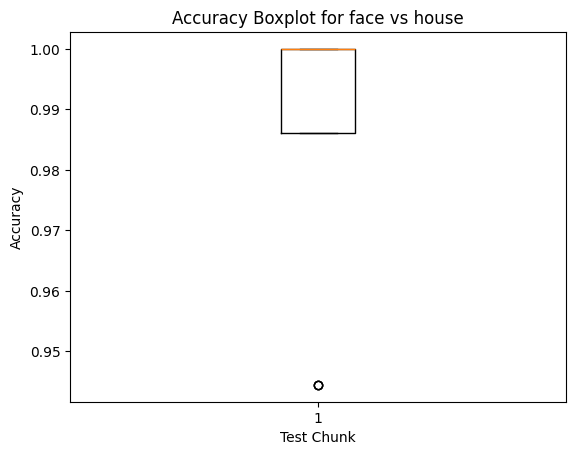

In [64]:
plt.boxplot(accuracy_values1)
plt.title('Accuracy Boxplot for face vs house')
plt.xlabel('Test Chunk')
plt.ylabel('Accuracy')
plt.show()

### Analysis of Feature Reduction on Classification Accuracy (Face vs. House)

#### 50% Random Features
- **Mean Accuracy across all chunks:** 0.9861111111111112
- **Standard Deviation of Accuracy:** 0.024056261216234415

#### All Features
- **Accuracy:** 1
- **Standard Deviation:** 0

#### Observations
- Limiting features reduces the classification accuracy, indicating that full feature access is critical for high accuracy.

- When using all features, the accuracy is perfect (1) with no deviation, indicating a highly stable model.

- Variability increases due to the reduced feature set, leading to less consistent performance.

- Multiple runs with different random feature selections show varying results, highlighting the importance of considering all features for consistent performance.


## FACE VS BOTTLES CLASSIFICATION

In [65]:
time_series = masker.fit_transform(subj2['func'][0])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/nilearn/image/resampling.py:489: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


In [66]:
# Restrict to face, house conditions here
conditions = behavioral["labels"]
mask = conditions.isin(["face", "bottle"])

# Filter the time series and conditions using the mask
X = time_series[mask]
Y = conditions[mask]

# Get the number of features (columns) in the time series
n_features = X.shape[1]

# Randomly select 50% of the features (columns)
random_feature_indices = np.random.choice(n_features, size=n_features // 2, replace=False)

# Select 50% random features
X_random = X[:, random_feature_indices]

# Print the shapes of the original and modified feature sets
print(f"Original time series shape: {X.shape}")
print(f"Shape with 50% random features: {X_random.shape}")

# Now X_random can be used for training and testing

X=X_random

print(X.shape)
print(Y.shape)

Original time series shape: (216, 464)
Shape with 50% random features: (216, 232)
(216, 232)
(216,)


In [67]:
from sklearn.svm import LinearSVC
svc=LinearSVC()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

svc.fit(X_train, y_train)
predicted_svc = svc.predict(X_test)

print("LinearSVC Accuracy:", accuracy_score(y_test, predicted_svc))

LinearSVC Accuracy: 0.9444444444444444


In [68]:
n_features = time_series.shape[1]
random_feature_indices = np.random.choice(n_features, size=n_features // 2, replace=False)
time_series=time_series[:, random_feature_indices]
print(time_series.shape)

(1452, 232)


In [72]:
accuracy_values2 = []

# Iterate through each of the 12 chunks (cross-validation)
for val in range(12):
    svc = LinearSVC()
    condition_mask_train = (mask) & (behavioral["chunks"] != val)
    condition_mask_test = (mask) & (behavioral["chunks"] == val)

    # Split the time series and labels based on the condition mask for training and testing
    X_train_selected = time_series[condition_mask_train]
    X_test_selected = time_series[condition_mask_test]
    y_train_selected = conditions[condition_mask_train]
    y_test_selected = conditions[condition_mask_test]

    # Check shapes of training and test sets for debugging
    # print(f"\nTrain set shape (chunk {val}): {X_train_selected.shape}")
    # print(f"Test set shape (chunk {val}): {X_test_selected.shape}")


    # Train the model on the training data
    svc.fit(X_train_selected, y_train_selected)

    # Predict the labels for the test data
    predicted_selected = svc.predict(X_test_selected)

    # Calculate accuracy for this chunk and append to the list
    accuracy = accuracy_score(y_test_selected, predicted_selected)
    accuracy_values2.append(accuracy)

    # Print the accuracy for the current chunk
    print(f"Accuracy for test chunk {val}: {accuracy}")



Accuracy for test chunk 0: 0.6111111111111112
Accuracy for test chunk 1: 0.9444444444444444
Accuracy for test chunk 2: 0.6111111111111112
Accuracy for test chunk 3: 0.5
Accuracy for test chunk 4: 1.0
Accuracy for test chunk 5: 0.9444444444444444
Accuracy for test chunk 6: 0.8888888888888888
Accuracy for test chunk 7: 0.8888888888888888
Accuracy for test chunk 8: 0.8888888888888888
Accuracy for test chunk 9: 1.0
Accuracy for test chunk 10: 1.0
Accuracy for test chunk 11: 0.9444444444444444


In [70]:
# Compute the mean and standard deviation of the accuracies
mean_accuracy = np.mean(accuracy_values2)
std_accuracy = np.std(accuracy_values2)

# Print the overall performance
print(f"\nMean Accuracy across all chunks: {mean_accuracy}")
print(f"Standard Deviation of Accuracy: {std_accuracy}")



Mean Accuracy across all chunks: 0.851851851851852
Standard Deviation of Accuracy: 0.1671802785672943


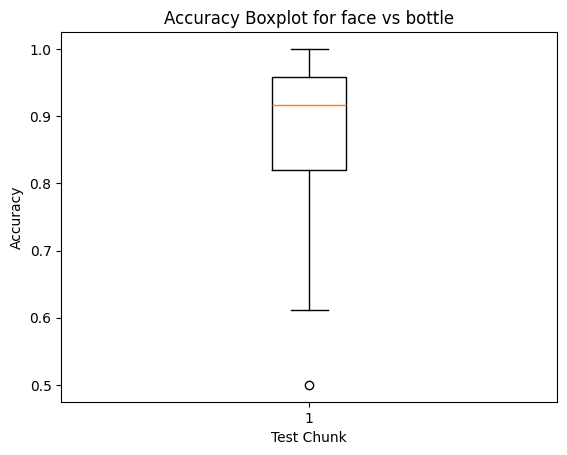

In [71]:
plt.boxplot(accuracy_values2)
plt.title('Accuracy Boxplot for face vs bottle')
plt.xlabel('Test Chunk')
plt.ylabel('Accuracy')
plt.show()

### 50% Features
- **Mean Accuracy across all chunks:** 0.851851851851852
- **Standard Deviation of Accuracy:** 0.1671802785672943

### All Features
- **Mean Accuracy across all chunks:** 0.8750000000000001
- **Standard Deviation of Accuracy:** 0.1418662356115237

## Conclusion

We observe that when using 50% random features, the accuracy is lower and the standard deviation is higher compared to using all features. This is expected as reducing the number of features provides less information for the model to learn , leading to varied results across different runs. This indicates the different significance of each voxel.


Additionally, when using all features, the accuracy for the face vs. bottle classification is lower compared to the face vs. house classification. The same trend is observed when using 50% random features. The drop in accuracy compared to "Face vs House" is due to shared low-level features between faces and bottles, which are less distinct with limited features.